In [38]:
import os
import argparse
from glob import glob
from functools import partial

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
from PIL import Image

import wandb

import jax
import jax.numpy as jnp
import flax

import torch
import torchvision.transforms as transforms
import tensorflow as tf
import tensorflow_datasets as tfds


class GANDataset(torch.utils.data.Dataset):
    def __init__(self, args):
        self.args = args

        self.paths_a = glob('./data/trainA/*.jpg')
        self.paths_b = glob('./data/trainB/*.jpg')

        self.imgs_a = np.zeros((len(self.paths_a), 32, 32, 3), dtype=np.float32)
        for i, path in tqdm(enumerate(self.paths_a)):
            img = np.asarray(Image.open(path)) / 255.0
            img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC).reshape(1, 32, 32, 3)
            self.imgs_a[i] = img

        self.imgs_b = np.zeros((len(self.paths_b), 32, 32, 3), dtype=np.float32)
        for i, path in tqdm(enumerate(self.paths_b)):
            img = np.asarray(Image.open(path)) / 255.0
            img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC).reshape(1, 32, 32, 3)
            self.imgs_b[i] = img

        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(hue=0.15),
            transforms.RandomGrayscale(p=0.25),
            transforms.RandomRotation(35),
            transforms.RandomPerspective(distortion_scale=0.35),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ])

    def __len__(self):
        return len(self.paths_a)

    def __getitem__(self, index):
        img_a = self.imgs_a[index]
        img_b = self.imgs_b[index]

        img_a = self.transforms(img_a).numpy().transpose(1,2,0)
        img_b = self.transforms(img_b).numpy().transpose(1,2,0)

        return img_a, img_b

In [39]:
dataset = GANDataset({})

3400it [00:08, 397.40it/s]
3400it [00:12, 281.43it/s]


In [40]:
%%timeit
img_a, img_b = dataset[0]

1.01 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
img_a, img_b = dataset[0]

In [42]:
img_a.shape

(32, 32, 3)

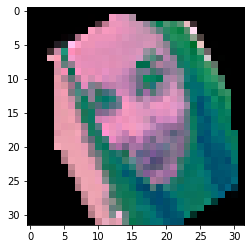

In [619]:
plt.imshow((img_a*0.5)+0.5)

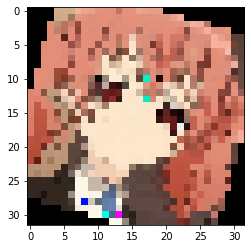

In [620]:
plt.imshow((img_b*0.5)+0.5)

In [621]:
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

In [622]:
for (img_a, img_b) in tqdm(train_dataloader):
    img_a = img_a
    img_b = img_b

100%|██████████| 14/14 [00:01<00:00, 11.73it/s]
